In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import shutil
import os
import oommfc as oc


import imageio
import math
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
from tqdm import tqdm

from mayavi import mlab
from mayavi.core.lut_manager import lut_mode_list, lut_image_dir


objc[42787]: Class QMacAutoReleasePoolTracker is implemented in both /Users/yejinhong/opt/anaconda3/envs/ubermag/lib/libQt5Core.5.15.6.dylib (0x16b8c12c8) and /Users/yejinhong/opt/anaconda3/envs/ubermag/lib/python3.9/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x17a6e9198). One of the two will be used. Which one is undefined.
objc[42787]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/yejinhong/opt/anaconda3/envs/ubermag/lib/libQt5Core.5.15.6.dylib (0x16b8c1340) and /Users/yejinhong/opt/anaconda3/envs/ubermag/lib/python3.9/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x17a6e9210). One of the two will be used. Which one is undefined.
objc[42787]: Class KeyValueObserver is implemented in both /Users/yejinhong/opt/anaconda3/envs/ubermag/lib/libQt5Core.5.15.6.dylib (0x16b8c1368) and /Users/yejinhong/opt/anaconda3/envs/ubermag/lib/python3.9/site-packages/PyQt5/Qt5/lib/QtCore.framework/

In [18]:
# GLOBAL VARIABLES
LOCATION = "/Users/yejinhong/ubermag-test"
DIR = "pulse10ns_rise_time_Jc3p2e12"
GLOBAL_H_X =  0.16 #(in T)
GLOBAL_H_Z =  0.03 #(in T)
GLOBAL_U = (0,0,1)
PULSE_DURATION1 = 10e-9  # Duration of Current Pulse / Change Duration
DIRC = -1          #-1 for positive current density
GLOBAL_JC  =  [3.2e12] # Current Density
VALUE=(0.001,0,1)

In [24]:

def time_func(t):
    trf = 10e-10
    if (T0<=t) and (t<(T0+trf)):
        current = (2.8e12/trf)*(t-T0)
    elif (T0+trf) <= t and t < (T0+trf+pulse_duration1):
        current = 2.8e12 
    elif (T0+trf+pulse_duration1) <= t and t < (T0+trf+pulse_duration1+trf):
        current = 2.8e12-(2.8e12/trf)*(t-T0-trf-pulse_duration1)
    else:
        current = 0
    return current
    
time = np.arange(0,30e-9,1e-9)
current = time_func(time)
plt.plot(time,current)
print(time)


# test 1
def time_func(t):
    trf = 10e-10
    if (T0<=t) and (t<(T0+trf)):
        current = (t-T0)/trf
    elif (T0+trf) <= t and t < (T0+trf+pulse_duration1):
        current = 1
    elif (T0+trf+pulse_duration1) <= t and t < (T0+trf+pulse_duration1+trf):
        current = (-1)*(t-T0-trf-pulse_duration1)/(trf)
    else:
        current = 0
    return current


# test 2, gave current error (current was defined too early)
def time_func(t):
    trf = 10e-10
    if (T0<=t) and (t<(T0+trf)):
        current = (2.8e12/trf)*(t-T0)
    elif (T0+trf) <= t and t < (T0+trf+pulse_duration1):
        current = 2.8e12 
    elif (T0+trf+pulse_duration1) <= t and t < (T0+trf+pulse_duration1+trf):
        current = 2.8e12-(2.8e12/trf)*(t-T0-trf-pulse_duration1)
    else:
        current = 0
    return current


# test 3
def time_func(t):
    trf = 1e-10
    if (T0<=t) and (t<(T0+trf)):
        current = (2.8e12/trf)*(t-T0)
        return current
    elif (T0+trf) <= t and t < (T0+trf+pulse_duration1):
        current = 2.8e12 
        return current
    elif (T0+trf+pulse_duration1) <= t and t < (T0+trf+pulse_duration1+trf):
        current = 2.8e12-(2.8e12/trf)*(t-T0-trf-pulse_duration1)
        return current


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [19]:
Ms = 1.0e6       # saturation magnetisation (A/m), 1200 emu/cc, 1 A/m = 0.012 Oe
A = 2.0e-11      # exchange energy constant (J/m)

alpha = 0.22    # Gilbert damping 
gamma0 = 2.211e5
K1 = 1.0e6       #Anisotropy Energy, the sample has PMA (normal 6.4e5, 0.5 mz for 4.0e5)
Hk = -(((4*3.14)-((2*K1*10)/(Ms*1e-3)))/1e4)

H_x =  GLOBAL_H_X # GLOBAL VAR IS USED.
H_z =  GLOBAL_H_Z # GLOBAL VAR IS USED.
H = 8e5 * np.array([H_x, 0.00, H_z]) # External Magnetic Field (T)

region = df.Region(p1 = (-100e-9, -100e-9, 0), p2 = (100e-9, 100e-9, 4e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 1e-9))
system = mm.System(name=DIR) # GLOBAL VAR IS USED.
system.energy = mm.Exchange(A=A) + mm.UniaxialAnisotropy(K=K1, u=GLOBAL_U) + mm.Demag() + mm.Zeeman(H=H) # GLOBAL VAR IS USED.

def Ms_fun(pos):
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 100e-9: # radius 
        return Ms
    else:
        return 0
#system.m = df.Field(mesh, dim=3, value(0, 0, 1), norm = Ms_fun)


  0%|          | 0/1 [00:00<?, ?it/s]

Running OOMMF (ExeOOMMFRunner)[2022/10/24 18:38]... (15.4 s)
Running OOMMF (ExeOOMMFRunner)[2022/10/24 18:38]... (1079.7 s)
Running OOMMF (ExeOOMMFRunner)[2022/10/24 18:56]... (2601.5 s)


100%|██████████| 1/1 [1:01:37<00:00, 3697.30s/it]


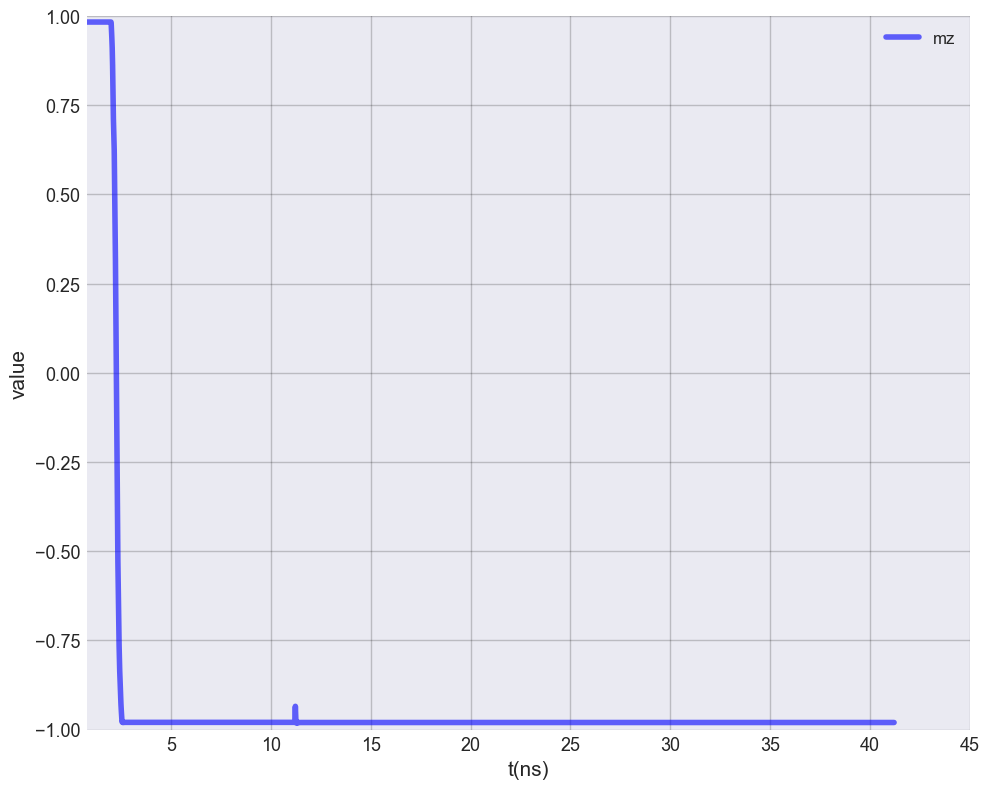

In [20]:
T0 = 1e-9
N0 = 100
trf = 1e-10
pulse_duration1 = PULSE_DURATION1  # Duration of Current Pulse / Change Duration # GLOBAL VAR IS USED.
p1 = trf*2 + pulse_duration1
N1 = 1000
pulse_duration2 = 30e-9  # Duration of Current Pulse / Leave it unchanged
N2 = 1000
dirc = DIRC          #-1 for positive current density # GLOBAL VAR IS USED.
Theta = 0.3         #0.4 
P = 1.0*Theta        #1.0*Theta // Change Theta
L = 1.0                #2.0 
ep_real = (P*L*L)/((L*L+1.0)+(L*L-1.0))
ep_imag = ep_real*0.05

Jc  =  GLOBAL_JC # Current Density

def time_func(t):
    if (T0<=t) and (t<(T0+trf)):
        current = (t-T0)/trf
    elif (T0+trf) <= t and t < (T0+trf+pulse_duration1):
        current = 1
    elif (T0+trf+pulse_duration1) <= t and t < (T0+trf+pulse_duration1+trf):
        current = (-1)*(t-T0-trf-pulse_duration1)/(trf)
    else:
        current = 0
    return current


#time_func = np.vectorize(time_func)



location = LOCATION # GLOBAL VAR IS USED.
dir = DIR # GLOBAL VAR IS USED.
path = os.path.join(location,dir)

# Trying to create a location+dir directory.
try: 
    os.mkdir(path) 
except OSError as error: 
    print(error)  

for i in tqdm(range(len(Jc))):
    shutil.rmtree(path)
    system = mm.System(name=DIR) # GLOBAL VAR IS USED.
    system.energy = mm.Exchange(A=A) + mm.Zeeman(H=H) + mm.UniaxialAnisotropy(K=K1, u=GLOBAL_U) + mm.Demag() # GLOBAL VAR IS USED.
    system.m = df.Field(mesh, dim=3, value=VALUE, norm=Ms_fun) # GLOBAL VAR IS USED.
    # value was (0, 0.01, 1) this is the direction we are initializing the magnetization
    
    system.dynamics =  mm.Damping(alpha=alpha)
    Jc1=Jc[i]
    td = oc.TimeDriver()
    td.drive(system, t=T0, n=N0)
    
    system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha) +  mm.Slonczewski(J= Jc1, mp = (0, dirc, 0), P = P, Lambda = L, eps_prime = ep_imag, func=time_func, dt=5e-13)
    td = oc.TimeDriver()
    td.drive(system, t=p1, n=N1)
    
    system.dynamics -= mm.Slonczewski(J = Jc1, mp = (0, dirc, 0), P = P, Lambda = L, eps_prime = ep_imag, func=time_func, dt=5e-13) # Same Result with the next two commands
    td = oc.TimeDriver()
    td.drive(system, t=pulse_duration2, n=N2)
    
    data = md.Data(name=system.name)
    drive45 = data[0]
    drive46 = data[1]
    drive47 = data[2]
    combined =  data[0] << data[1] << data[2]
    
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    combined.table.mpl(ax=ax,x="t", y=["mz"], color='b',linewidth= 4,alpha=0.6,)
    ax.grid('on',color='k', linewidth=1,alpha=0.2)
    ax.set_ylim(-1,1)
    ax.set_xlim(0.8,45)
    
    plt.tight_layout()
    #plt.savefig(path+'Co70Gd30_CoPt_in_ex_'+str('%.2e' % ((in_ex_1+j*dex)*100))+'_power_'+str('%.2e' % ((Ain+i*dA)*1.2))+'_Koopmans_100fs.jpg', dpi=300)
    
    
    plt.savefig(path+".jpg".format(i=i*1e12),dpi=90)
    
#+ mm.DMI(D=0.8e-3, crystalclass="Cnv") +mm.Demag() 

# Shading the region

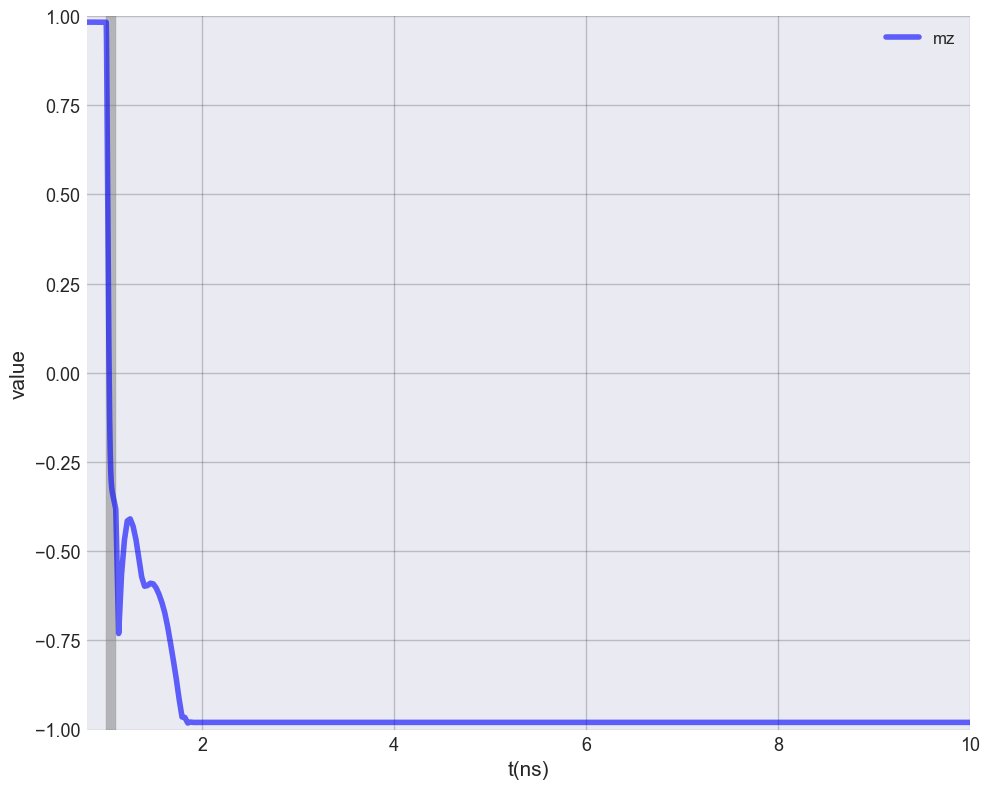

In [101]:
data = md.Data(name="_100ps_test11")
drive45 = data[0]
drive46 = data[1]
drive47 = data[2]
combined =  data[0] << data[1] << data[2]
    
    
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
combined.table.mpl(ax=ax,x="t", y=["mz"], color='b',linewidth= 4,alpha=0.6,)
ax.grid('on',color='k', linewidth=1,alpha=0.2)
ax.set_ylim(-1,1)
ax.set_xlim(0.8,10)
line1 = 1
line2 = 1.1
ax.axvspan(line1,line2,alpha=0.5,color='gray')


plt.tight_layout()
plt.savefig(path+"_ver2.jpg".format(i=i*1e12),dpi=90)

# Spin Visualization / try to fix this

In [57]:
spin_dir = "spin"+DIR

path1 = os.path.join(LOCATION,spin_dir)

# Trying to create a location+dir directory.
try: 
    os.mkdir(path1) 
except OSError as error: 
    print(error)  
    



data = md.Data(name=DIR)
combined =  data[0] << data[1] << data[2]
for i in range(210):
    i = i*10
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    combined[i].z.plane('z').mpl.scalar(ax=ax,cmap='bwr', clim=(-1e6, 1e6))
    combined[i].plane('z',n=(10,10)).mpl.vector(ax=ax,color_field=combined[i].z,colorbar=False, colorbar_label='vector', cmap='pink',clim=(-1e6,1e6))
    plt.tight_layout()
    filename ='_{:04d}.jpg'.format(i)
    plt.savefig(path1 + filename)
    plt.close()
    


[Errno 17] File exists: '/Users/yejinhong/ubermag-test/spin_500ps_test3'


KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

In [21]:

location = "/Users/yejinhong/ubermag-test"
dir = "pulse10ns_rise_time_Jc3p2e12"
path = os.path.join(location,dir)

import imageio
data = md.Data(name=dir)
combined =  data[0] << data[1] << data[2]
for i in range(210):
    i = i*10
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    combined[i].z.plane('z').mpl.scalar(ax=ax,cmap='bwr', clim=(-1e6, 1e6))
    combined[i].plane('z',n=(10,10)).mpl.vector(ax=ax,color_field=combined[i].z,colorbar=False, colorbar_label='vector', cmap='pink',clim=(-1e6,1e6))
    plt.tight_layout()
    #dir1 = "spin_10ns_test2"
    #path1 = os.path.join(location,dir1)
    plt.savefig('spin_pulse10ns_rise_time_Jc3p2e12/{:04d}.jpg'.format(i),dpi=90)
    plt.close()

# Mayavi

In [6]:
import mayavi
from mayavi import mlab
mlab.init_notebook('_10ns_test1-Oxs_TimeDriver-Magnetization-0000000-0000079.vtk')
v = mayavi()
d = v.open_vtk('_10ns_test1-Oxs_TimeDriver-Magnetization-0000000-0000079.vtk',config=0)
f = v.load_filter('WarpScalar', config=0)
n = v.load_filter('PolyDataNormals', 0)
n.fil.SetFeatureAngle (45)
m = v.load_module('SurfaceMap', 0)
a = v.load_module('Axes', 0)
a.axes.SetCornerOffset(0.0)
o = v.load_module('Outline', 0)
v.Render()


AssertionError: Backend must be one of dict_keys(['itk', 'ipy', 'x3d', 'png']), got _10ns_test1-Oxs_TimeDriver-Magnetization-0000000-0000079.vtk

AttributeError: Object has no attribute table.

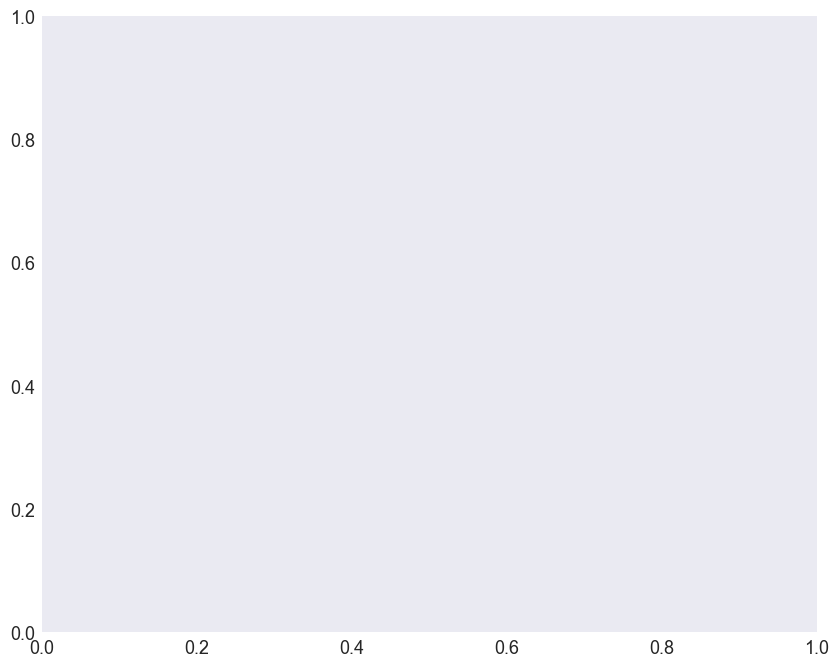

In [37]:
location = "/Users/yejinhong/ubermag-test"
dir = "_10ns_test1"
path = os.path.join(location,dir)


import imageio
data = md.Data(name=dir)
combined =  data[0] << data[1] << data[2]
for i in range(210):
    i = i*10
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    x = combined[i].table.data['mx'].values
    y = combined[i].table.data['my'].values
    z = combined[i].table.data['mz'].values
    mlab.quiver3d(x,y,z)
    #combined[i].z.plane('z').mpl.scalar(ax=ax,cmap='bwr', clim=(-1e6, 1e6))
    #combined[i].plane('z',n=(10,10)).mpl.vector(ax=ax,color_field=combined[i].z,colorbar=False, colorbar_label='vector', cmap='pink',clim=(-1e6,1e6))
    plt.tight_layout()
    #dir1 = "spin_10ns_test2"
    #path1 = os.path.join(location,dir1)
    plt.savefig('spin_10ns_test1_mayavi/{:04d}.jpg'.format(i),dpi=90)
    plt.close()   
    
    
    
    
#>>> import mayavi
#>>> v = mayavi.mayavi() # create a MayaVi window.
#>>> d = v.open_vtk('/tmp/test.vtk', config=0) # open the data file.
#>>> # The config option turns on/off showing a GUI control for the data/filter/module.
#>>> # load the filters.
#>>> f = v.load_filter('WarpScalar', config=0) 
#>>> n = v.load_filter('PolyDataNormals', 0)
#>>> n.fil.SetFeatureAngle (45) # configure the normals.
#>>> # Load the necessary modules.
#>>> m = v.load_module('SurfaceMap', 0)
#>>> a = v.load_module('Axes', 0)
#>>> a.axes.SetCornerOffset(0.0) # configure the axes module.
#>>> o = v.load_module('Outline', 0)
#>>> v.Render() # Re-render the scene.

In [ ]:
data = md.Data(name=system.name)
drive45 = data[3]
drive46 = data[4]
drive47 = data[5]
combined =  data[3] << data[4] << data[5]


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
combined.table.mpl(ax=ax,x="t", y=["mz"], color='b',linewidth= 4,alpha=0.6,)
ax.grid('on',color='k', linewidth=1,alpha=0.2)
ax.set_ylim(-1,1)
ax.set_xlim(0.8,30)
plt.tight_layout()
#plt.savefig(path+'Co70Gd30_CoPt_in_ex_'+str('%.2e' % ((in_ex_1+j*dex)*100))+'_power_'+str('%.2e' % ((Ain+i*dA)*1.2))+'_Koopmans_100fs.jpg', dpi=300)


#plt.savefig(path+".jpg".format(i=i*1e12),dpi=90)

## Visulization

In [ ]:
#path = '/Users/SimulationComputer/Documents/Yoselyn/Duration/Duration 10/'

for i in range(210):
    i = i*10
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    combined[i].z.plane('z').mpl.scalar(ax=ax,cmap='bwr', clim=(-1e6, 1e6))
    combined[i].plane('z',n=(10,10)).mpl.vector(ax=ax,color_field=combined[i].z,colorbar=False, colorbar_label='vector', cmap='pink',clim=(-1e6,1e6))
    plt.tight_layout()
    plt.savefig(path1+'test1_10ns'+'{i}.jpg'.format(i=i),dpi=90)
    plt.close()

In [ ]:
for i in range(1,21):
    print("{:04d}".format(i))

In [ ]:

location = "/Users/yejinhong/ubermag-test"
dir = "_10ns_test8"
path = os.path.join(location,dir)

import imageio
data = md.Data(name=dir)
combined =  data[0] << data[1] << data[2]
for i in range(210):
    i = i*10
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    
    combined[i].z.plane('z').mpl.scalar(ax=ax,cmap='bwr', clim=(-1e6, 1e6))
    combined[i]plane('z',n=(10,10)).mpl.vector(ax=ax,color_field=combined[i].z,colorbar=False, colorbar_label='vector', cmap='pink',clim=(-1e6,1e6))
    plt.tight_layout()
    #dir1 = "spin_10ns_test2"
    #path1 = os.path.join(location,dir1)
    plt.savefig('spin_10ns_test8/{:04d}.jpg'.format(i),dpi=90)
    plt.close()

In [ ]:
gif_path = path+"After_Duration_20.gif"
frames_path = path+"{i}.jpg"

with imageio.get_writer(gif_path, mode='I',duration=0.05) as writer:
    for i in range(210):
        writer.append_data(imageio.imread(frames_path.format(i=i*10)))

## Save Data

In [ ]:
#path1 = '/Users/SimulationComputer/Documents/Yoselyn/'
path1 = '/Users/yejinhong/ubermag-test/test1_10ns'
t = combined.table.data['t'].values
Mz = combined.table.data['mz'].values
np.savetxt('Jc = ', (Jc), 'Hx = ', (Hx), 'Hz = ', (Hz))
np.savetxt(path1+'3p0_current_density.txt', (t, Mz),fmt='%1.5e', delimiter =',', header = 'Time (ns), Mz')
 

In [ ]:

t = combined.table.data['t'].values 
Mz = combined.table.data['mz'].values
Mx = combined.table.data['mx'].values
My = combined.table.data['my'].values

Jc_=2.8e12

z = np.piecewise(t,[t<1e-9,((t>=1e-9) & (t<=11e-9)),t>11e-9],[0,Jc_,0])
    
f = open('_10ns_test8.txt','w')

arr1 = np.column_stack(([Jc_, H_x, H_z]))
np.savetxt(f,arr1,fmt='%.2e', delimiter =', ', header = 'Jc, Hx, Hz')
arr2 = np.column_stack((t,Mx,My,Mz))
np.savetxt(f, arr2,fmt='%1.5e', delimiter =', ', header = 'Time, Mx, My, Mz')

#t1 = np.linspace(10e-12,1000e-12,100)
#t2 = np.delete(t1, 99)
#t3 = np.linspace(1000e-12, 1500e-12, 1000)
#t4 = np.concatenate(([0],t2,t3))

t_ns = t*1e9 

#print(t4)
#print(t)


print(z)

Fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(1,1,1)
ax1.plot(t_ns,Mz,'b', linewidth=4,label='$M_{z}$')
#ax1.plot(t,Mz,'b',linewidth=4)

#ax1.set_xlim(0, 100e-12)
ax1.set_ylim(-1.0, 1.2)
ax1.tick_params(direction='in',length=6, width=2, colors='k',grid_color='k',grid_alpha=0.5,labelsize=20)
ax1.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax1.set_xlabel('Time (ns)',fontsize=20)
ax1.set_ylabel('$M_{z}$',fontsize=20)
ax1.legend(loc=4,handlelength=2, fontsize=20)
#np.array([])

ax2 = ax1.twinx()
ax2.plot(t_ns, z, 'r', linewidth=4,label='$J_{c}$')
ax2.tick_params(direction='in',length=6, width=2, colors='k',grid_color='k',grid_alpha=0.5,labelsize=20)
ax2.set_yticks(np.linspace(-4e12,4e12,9))
ax2.set_ylabel('$J_{c}$',fontsize=20)
ax2.legend(loc=3,handlelength=2, fontsize=20)
#ax2.set_xlim(0,150e-12)
#ax2.set_ylim(-1.6,1.6)
#
plt.tight_layout()
plt.savefig('plot_10ns_test8.jpg', dpi=500)
plt.show()

### Plot Data

In [ ]:
path1 = '/Users/SimulationComputer/Documents/Yoselyn/test2/'

duration_20_n = np.genfromtxt(path1+'Duration_20.txt', skip_header=1,delimiter=',')





Fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(1,1,1)
ax1.plot((duration_20_n[0]/1e-12) -1000, duration_20_n[1], 'r', linewidth=4,label='20 ps_$6.8 x 10^{12} A/m^{2}$')
ax1.axvspan(0, 20, facecolor='g', alpha=0.3)
ax1.set_xlim(-20, 300)
ax1.tick_params(direction='in',length=6, width=2, colors='k',grid_color='k',grid_alpha=0.5,labelsize=20)
ax1.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax1.set_xlabel('Time (ps)',fontsize=20)
ax1.set_ylabel('$M_{z}$',fontsize=20)
ax1.legend(loc=1,handlelength=2, fontsize=20)
plt.tight_layout()
plt.savefig(path1+'Current Pulse 20.jpg', dpi=500)
plt.show()

In [ ]:
path1 = '/Users/SimulationComputer/Documents/Yoselyn/'
duration_5 = np.genfromtxt(path1+'Duration_5.txt',skip_header=1, delimiter=',')
duration_10 = np.genfromtxt(path1+'Duration_10.txt', skip_header=1,delimiter=',')
duration_15 = np.genfromtxt(path1+'Duration_15.txt', skip_header=1,delimiter=',')
duration_20 = np.genfromtxt(path1+'Duration_20.txt', skip_header=1,delimiter=',')
duration_25 = np.genfromtxt(path1+'Duration_25.txt', skip_header=1,delimiter=',')
duration_30 = np.genfromtxt(path1+'Duration_30.txt', skip_header=1,delimiter=',')
duration_10_5C = np.genfromtxt(path1+'Duration_10_5C.txt', skip_header=1,delimiter=',')
duration_10_55C = np.genfromtxt(path1+'Duration_10_5.5C.txt', skip_header=1,delimiter=',')
duration_10_6C = np.genfromtxt(path1+'Duration_10_6.0C.txt', skip_header=1,delimiter=',')
duration_10_65C = np.genfromtxt(path1+'Duration_10_6.5C.txt', skip_header=1,delimiter=',')
duration_10_7C = np.genfromtxt(path1+'Duration_10_7.0C.txt', skip_header=1,delimiter=',')

In [ ]:
#Change colors and figure out why it's not working

plt.plot(duration_5[0]/1e-9, duration_5[1], 'r', linewidth=4)
#plt.plot(duration_10[0]/1e-9, duration_10[1], 'k', linewidth=4)
plt.plot(duration_15[0]/1e-9, duration_15[1], 'b', linewidth=4)
plt.plot(duration_20[0]/1e-9, duration_20[1], 'c', linewidth=4)
plt.plot(duration_25[0]/1e-9, duration_25[1], 'g', linewidth=4)
plt.plot(duration_30[0]/1e-9, duration_30[1], 'y', linewidth=4)




#plt.savefig(path1+'Duration increments of 5s.jpg', dpi=500)
plt.xlabel('Time ns')
plt.ylabel('Mz')
plt.xlim([0.95, 1.5])
plt.savefig(path1+'Current Pulse Width increments of 5s.jpg', dpi=500)
plt.show

In [ ]:
path = '/Users/SimulationComputer/Documents/Yoselyn/test3/'
path1 = '/Users/SimulationComputer/Documents/Yoselyn/test3/'
path2 = '/Users/SimulationComputer/Documents/Yoselyn/test4/'
path3 = '/Users/SimulationComputer/Documents/Yoselyn/test5/'
path4 = '/Users/SimulationComputer/Documents/Yoselyn/test6/'
path5 = '/Users/SimulationComputer/Documents/Yoselyn/test7/'
path6 = '/Users/SimulationComputer/Documents/Yoselyn/test8/'

duration_10_3C = np.genfromtxt(path1+'3p0_current_density.txt', skip_header=1,delimiter=',')
duration_10_4C = np.genfromtxt(path2+'4p0_current_density.txt', skip_header=1,delimiter=',')
duration_10_5C = np.genfromtxt(path3+'5p0_current_density.txt', skip_header=1,delimiter=',')
duration_10_6C = np.genfromtxt(path4+'6p0_current_density.txt', skip_header=1,delimiter=',')
duration_10_7C = np.genfromtxt(path5+'7p0_current_density.txt', skip_header=1,delimiter=',')
duration_10_8C = np.genfromtxt(path6+'8p0_current_density.txt', skip_header=1,delimiter=',')

In [ ]:
Fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(1,1,1)

ax1.axvspan(0, 20, facecolor='g', alpha=0.3)

ax1.plot((duration_10_3C[0]/1e-12)-1000, duration_10_3C[1], 'r', linewidth=4, label='$3 x 10^{12} A/m^{2}$')
ax1.plot((duration_10_4C[0]/1e-12)-1000, duration_10_4C[1], 'k', linewidth=4,label='$4 x 10^{12} A/m^{2}$', )
ax1.plot((duration_10_5C[0]/1e-12)-1000, duration_10_5C[1], 'yellow', linewidth=4,label='$5 x 10^{12} A/m^{2}$')
ax1.plot((duration_10_6C[0]/1e-12)-1000, duration_10_6C[1], 'g', linewidth=4,label='$6 x 10^{12} A/m^{2}$')
ax1.plot((duration_10_7C[0]/1e-12)-1000, duration_10_7C[1], 'teal', linewidth=4,label='$7 x 10^{12} A/m^{2}$')
#ax1.plot((duration_10_8C[0]/1e-12)-1000, duration_10_8C[1], 'b', linewidth=4,label='$8 x 10^{12} A/m^{2}$')               
#plt.savefig(path1+'Duration increments of 5s.jpg', dpi=500)

ax1.set_xlim(-20, 300)
ax1.tick_params(direction='in',length=6, width=2, colors='k',grid_color='k',grid_alpha=0.5,labelsize=20)
ax1.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax1.set_xlabel('Time (ps)',fontsize=20)
ax1.set_ylabel('$M_{z}$',fontsize=20)
ax1.legend(loc=1,handlelength=2, fontsize=20)
plt.tight_layout()



plt.savefig(path1+'Current Density_20ps.jpg', dpi=500)
plt.show()

## Save Data

In [ ]:
#path2 = '/Users/SimulationComputer/Documents/Yoselyn/Duration/test/'
#gif_path = path2+"Duration_10_7.0C.gif"
#frames_path = path2+"{i}.jpg"

#with imageio.get_writer(gif_path, mode='I',duration=0.4) as writer:
#    for i in range(47):
#        writer.append_data(imageio.imread(frames_path.format(i=850+i*10)))